## Import Libraries

In [29]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os

import spacy
nlp = spacy.load("fr_core_news_lg")
nlp.add_pipe("merge_noun_chunks")
nlp.add_pipe("merge_entities")


# Import Stop words 
from spacy.lang.fr.stop_words import STOP_WORDS


from spellchecker import SpellChecker
spell = SpellChecker(language='fr')

## Concatenate Extractions from different keywords

In [33]:
path = 'C:\\Users\\awasa\\Documents\\data4good\\quota_climat\\data\\keywords'
excel = os.listdir(path)
excel

['20221015_lastmonth_all_activiste.xlsx',
 '20221015_lastmonth_all_biodiversité.xlsx',
 '20221015_lastmonth_all_changement climatique.xlsx',
 '20221015_lastmonth_all_décroissance.xlsx',
 '20221015_lastmonth_all_GIEC.xlsx',
 '20221015_lastmonth_all_réchauffement climatique.xlsx',
 '20221015_lastweek_all_sobriété.xlsx',
 '20221015_lastyear_bfmtv_changement climatique.xlsx']

In [34]:
df = pd.DataFrame()
for f in excel:
    file = pd.read_excel(path+'\\'+f)
    df = pd.concat([df,file]).reset_index(drop=True)

print('colonnes: ',df.columns)
print('format: ',df.shape)

colonnes:  Index(['CHANNEL', 'RADIO', 'DATE', 'TEXT', 'HIGHLIGHT', 'START CHUNK',
       'END CHUNK', 'ORIGIN', 'URL'],
      dtype='object')
format:  (32073, 9)


In [35]:
# Check duplicates
print('nb of duplicates: ', df.duplicated().sum())

# Remove duplicates
df.drop_duplicates(ignore_index=True, inplace=True)

print('nb of duplicates after drop_duplicates: ', df.duplicated().sum())

nb of duplicates:  215
nb of duplicates after drop_duplicates:  0


In [36]:
df = df.drop(index=557).reset_index(drop=True)

#info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31857 entries, 0 to 31856
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CHANNEL      31857 non-null  object
 1   RADIO        31857 non-null  bool  
 2   DATE         31857 non-null  object
 3   TEXT         31857 non-null  object
 4   HIGHLIGHT    31857 non-null  object
 5   START CHUNK  31857 non-null  object
 6   END CHUNK    31857 non-null  object
 7   ORIGIN       31857 non-null  object
 8   URL          31857 non-null  object
dtypes: bool(1), object(8)
memory usage: 2.0+ MB


In [37]:
# mise en forme des champs date et heure

df['start_date'] = df['START CHUNK'].apply(lambda x: x.split('T')[0]+' '+x.split('T')[1].replace('-',':'))
df['start_date'] = pd.to_datetime(df.start_date)

df['end_date'] = df['END CHUNK'].apply(lambda x: x.split('T')[0]+' '+x.split('T')[1].replace('-',':'))
df['end_date'] = pd.to_datetime(df.end_date)

df['duration'] = df.end_date - df.start_date
df['duration'] = df.duration / pd.Timedelta(minutes=1)

## Text Preprocessing

In [38]:
# Take sample of 100 rows for faster processing
df_ = df.sample(100).reset_index(drop=True)
df_.head()

,CHANNEL,RADIO,DATE,TEXT,HIGHLIGHT,START CHUNK,END CHUNK,ORIGIN,URL,start_date,end_date,duration
0,fbleu-provence,True,2022-10-05T16-20-00,tout est nouveau redessiner le cur vidéo <unk>...,des initiatives vous nous parlez d' un atlas ...,2022-10-05T16-20-00,2022-10-05T16-22-00,s2t,https://keywords.mediatree.fr/player/?fifo=fbl...,2022-10-05 16:20:00,2022-10-05 16:22:00,2.0
1,euronews,False,2022-09-23T22-36-00,youm une ville reprise par les forces ukrainie...,youm une ville reprise par les forces ukrainie...,2022-09-23T22-36-00,2022-09-23T22-38-00,s2t,https://keywords.mediatree.fr/player/?fifo=eur...,2022-09-23 22:36:00,2022-09-23 22:38:00,2.0
2,bfmlyon,False,2022-10-11T21-10-00,opposition avec un groupe transpartisan qui a ...,ont été faites pour arriver à ce plan de sobr...,2022-10-11T21-10-00,2022-10-11T21-12-00,s2t,https://keywords.mediatree.fr/player/?fifo=bfm...,2022-10-11 21:10:00,2022-10-11 21:12:00,2.0
3,itele,False,2022-10-12T09-22-00,bon et a toujours eu à en quatre-vingt quinze ...,insécurité en matière de maintenance sobriété...,2022-10-12T09-22-00,2022-10-12T09-24-00,s2t,https://keywords.mediatree.fr/player/?fifo=ite...,2022-10-12 09:22:00,2022-10-12 09:24:00,2.0
4,fr3-idf,False,2022-09-15T09-10-00,il et elle sillonne les mers du globe où gravi...,de nos océans biodiversité ou encore rencontr...,2022-09-15T09-10-00,2022-09-15T09-12-00,s2t,https://keywords.mediatree.fr/player/?fifo=fr3...,2022-09-15 09:10:00,2022-09-15 09:12:00,2.0


In [39]:
# Remove '<unk>'
df_['clean_text'] = df_.TEXT.apply(lambda x: x.replace('<unk>','').strip())

In [40]:
# Import TEXT CLASSIFICATION Transformer

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TextClassificationPipeline

model_name = 'lincoln/flaubert-mlsum-topic-classification'

loaded_tokenizer = AutoTokenizer.from_pretrained(model_name)
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = TextClassificationPipeline(model=loaded_model, tokenizer=loaded_tokenizer)
classifier("Le Bayern Munich prend la grenadine.", truncation=True)

[{'label': 'Sport', 'score': 0.9970038533210754}]

In [41]:
# import RE PUNCTUATION library

from deepmultilingualpunctuation import PunctuationModel

sample_text = df_.clean_text[0]
model = PunctuationModel()
result = model.restore_punctuation(sample_text)
print(result)

tout est nouveau, redessiner le cur. vidéo zaz, à l' instant, tout là haut, qui nous emmène tout là haut, sur france bleu, provence, ces dix-huit, france, c' est la provence, une animation à seize heures vingt. nous allons rester ici bas, et c' est pas plus mal, pour s' occuper un petit peu mieux de ce qui nous entoure. evan adeline et dans le tour de france des initiatives, vous nous parlez d' un atlas de la biodiversité qu' on peut réaliser chez nous, en provence, dans nos communes. c' est génial, ça, oui, oui, ils sont déjà plus de deux mille quatre cents villages à avoir initié l' inventaire de leur biodiversité locale. mal, ce qui est souhaite dans ce projet, c' est que les travaux de recensement sont réalisés par les citoyens eux-mêmes, l' un des objectifs étant d' apprendre à connaître la faune et la flore qui vous entoure pour mieux la préserver. c' est une initiative soutenue par l' office français de la biodiversité. elle permet également aux élus locaux de prendre des décisi

In [42]:
# Apply re-punctuation and split text by sentences
df_['clean_text'] = df_.clean_text.apply(lambda x: model.restore_punctuation(x))
df_['clean_text'] = df_.clean_text.apply(lambda x: [s.strip().capitalize() for s in x.split(".") if len(s.strip()) > 0])
df_.clean_text[0]

['Tout est nouveau, redessiner le cur',
 "Vidéo zaz, à l' instant, tout là haut, qui nous emmène tout là haut, sur france bleu, provence, ces dix-huit, france, c' est la provence, une animation à seize heures vingt",
 "Nous allons rester ici bas, et c' est pas plus mal, pour s' occuper un petit peu mieux de ce qui nous entoure",
 "Evan adeline et dans le tour de france des initiatives, vous nous parlez d' un atlas de la biodiversité qu' on peut réaliser chez nous, en provence, dans nos communes",
 "C' est génial, ça, oui, oui, ils sont déjà plus de deux mille quatre cents villages à avoir initié l' inventaire de leur biodiversité locale",
 "Mal, ce qui est souhaite dans ce projet, c' est que les travaux de recensement sont réalisés par les citoyens eux-mêmes, l' un des objectifs étant d' apprendre à connaître la faune et la flore qui vous entoure pour mieux la préserver",
 "C' est une initiative soutenue par l' office français de la biodiversité",
 "Elle permet également aux élus locau

In [43]:
# Explode 'clean_text' to get separate row for each sentence.
# Use text classification pipeline to get topic and score for each sentence

df_ = df_.explode('clean_text')
df_['topic'] = df_.clean_text.apply(lambda x: classifier(x, truncation=True))
df_['score'] = df_.topic.apply(lambda x: x[0]['score'])
df_['topic'] = df_.topic.apply(lambda x: x[0]['label'])

df_.head()

,CHANNEL,RADIO,DATE,TEXT,HIGHLIGHT,START CHUNK,END CHUNK,ORIGIN,URL,start_date,end_date,duration,clean_text,topic,score
0,fbleu-provence,True,2022-10-05T16-20-00,tout est nouveau redessiner le cur vidéo <unk>...,des initiatives vous nous parlez d' un atlas ...,2022-10-05T16-20-00,2022-10-05T16-22-00,s2t,https://keywords.mediatree.fr/player/?fifo=fbl...,2022-10-05 16:20:00,2022-10-05 16:22:00,2.0,"Tout est nouveau, redessiner le cur",Culture,0.471391
0,fbleu-provence,True,2022-10-05T16-20-00,tout est nouveau redessiner le cur vidéo <unk>...,des initiatives vous nous parlez d' un atlas ...,2022-10-05T16-20-00,2022-10-05T16-22-00,s2t,https://keywords.mediatree.fr/player/?fifo=fbl...,2022-10-05 16:20:00,2022-10-05 16:22:00,2.0,"Vidéo zaz, à l' instant, tout là haut, qui nou...",Culture,0.632358
0,fbleu-provence,True,2022-10-05T16-20-00,tout est nouveau redessiner le cur vidéo <unk>...,des initiatives vous nous parlez d' un atlas ...,2022-10-05T16-20-00,2022-10-05T16-22-00,s2t,https://keywords.mediatree.fr/player/?fifo=fbl...,2022-10-05 16:20:00,2022-10-05 16:22:00,2.0,"Nous allons rester ici bas, et c' est pas plus...",Technologie,0.660138
0,fbleu-provence,True,2022-10-05T16-20-00,tout est nouveau redessiner le cur vidéo <unk>...,des initiatives vous nous parlez d' un atlas ...,2022-10-05T16-20-00,2022-10-05T16-22-00,s2t,https://keywords.mediatree.fr/player/?fifo=fbl...,2022-10-05 16:20:00,2022-10-05 16:22:00,2.0,Evan adeline et dans le tour de france des ini...,Environement,0.760211
0,fbleu-provence,True,2022-10-05T16-20-00,tout est nouveau redessiner le cur vidéo <unk>...,des initiatives vous nous parlez d' un atlas ...,2022-10-05T16-20-00,2022-10-05T16-22-00,s2t,https://keywords.mediatree.fr/player/?fifo=fbl...,2022-10-05 16:20:00,2022-10-05 16:22:00,2.0,"C' est génial, ça, oui, oui, ils sont déjà plu...",Environement,0.705987


In [44]:
# Create embeddings for each sentence with sentence transformer

from sentence_transformers import SentenceTransformer
model = SentenceTransformer("dangvantuan/sentence-camembert-large")

df_['embedding'] = df_.clean_text.apply(lambda x: model.encode(x))

No sentence-transformers model found with name C:\Users\awasa/.cache\torch\sentence_transformers\dangvantuan_sentence-camembert-large. Creating a new one with MEAN pooling.


In [45]:
# Get length of each sentence

df_['length'] = df_.clean_text.apply(lambda x: len(x))
df_.reset_index(inplace=True)

index_length = df_.groupby('index', as_index=False).sum()['length'].reset_index()
index_length.columns = ['index','total_length']
index_length

,index,total_length
0,0,1088
1,1,1934
2,2,2306
3,3,2255
4,4,2099
...,...,...
95,95,2202
96,96,2055
97,97,1862
98,98,2355


In [46]:
# Calculate the time dedicated for each sentence 
# determine % of time used for each sentence, then multiply % of time by total duration)

df_ = df_.merge(index_length, how='left')
df_['%_of_time'] = (df_.length/df_.total_length*100).round(1)
df_['duration_topic'] = df_.duration * df_['%_of_time']
df_.head()

,index,CHANNEL,RADIO,DATE,TEXT,HIGHLIGHT,START CHUNK,END CHUNK,ORIGIN,URL,...,end_date,duration,clean_text,topic,score,embedding,length,total_length,%_of_time,duration_topic
0,0,fbleu-provence,True,2022-10-05T16-20-00,tout est nouveau redessiner le cur vidéo <unk>...,des initiatives vous nous parlez d' un atlas ...,2022-10-05T16-20-00,2022-10-05T16-22-00,s2t,https://keywords.mediatree.fr/player/?fifo=fbl...,...,2022-10-05 16:22:00,2.0,"Tout est nouveau, redessiner le cur",Culture,0.471391,"[-0.34050825, -0.045020536, 0.10515621, -0.296...",35,1088,3.2,6.4
1,0,fbleu-provence,True,2022-10-05T16-20-00,tout est nouveau redessiner le cur vidéo <unk>...,des initiatives vous nous parlez d' un atlas ...,2022-10-05T16-20-00,2022-10-05T16-22-00,s2t,https://keywords.mediatree.fr/player/?fifo=fbl...,...,2022-10-05 16:22:00,2.0,"Vidéo zaz, à l' instant, tout là haut, qui nou...",Culture,0.632358,"[-0.014821108, 0.37653404, 0.16810067, 0.35504...",172,1088,15.8,31.6
2,0,fbleu-provence,True,2022-10-05T16-20-00,tout est nouveau redessiner le cur vidéo <unk>...,des initiatives vous nous parlez d' un atlas ...,2022-10-05T16-20-00,2022-10-05T16-22-00,s2t,https://keywords.mediatree.fr/player/?fifo=fbl...,...,2022-10-05 16:22:00,2.0,"Nous allons rester ici bas, et c' est pas plus...",Technologie,0.660138,"[-0.062644646, -0.07485832, 0.4002879, -0.1496...",109,1088,10.0,20.0
3,0,fbleu-provence,True,2022-10-05T16-20-00,tout est nouveau redessiner le cur vidéo <unk>...,des initiatives vous nous parlez d' un atlas ...,2022-10-05T16-20-00,2022-10-05T16-22-00,s2t,https://keywords.mediatree.fr/player/?fifo=fbl...,...,2022-10-05 16:22:00,2.0,Evan adeline et dans le tour de france des ini...,Environement,0.760211,"[-0.23860705, 0.08348947, -0.09967969, 0.13456...",166,1088,15.3,30.6
4,0,fbleu-provence,True,2022-10-05T16-20-00,tout est nouveau redessiner le cur vidéo <unk>...,des initiatives vous nous parlez d' un atlas ...,2022-10-05T16-20-00,2022-10-05T16-22-00,s2t,https://keywords.mediatree.fr/player/?fifo=fbl...,...,2022-10-05 16:22:00,2.0,"C' est génial, ça, oui, oui, ils sont déjà plu...",Environement,0.705987,"[-0.03125396, -0.26751557, 0.047921114, -0.655...",140,1088,12.9,25.8


In [47]:
# Only keep rows with topic Environment

df_env = df_[df_.topic=='Environement'].reset_index(drop=True)

embeddings = np.stack(df_env.embedding)
len(embeddings)

427

## Clustering 

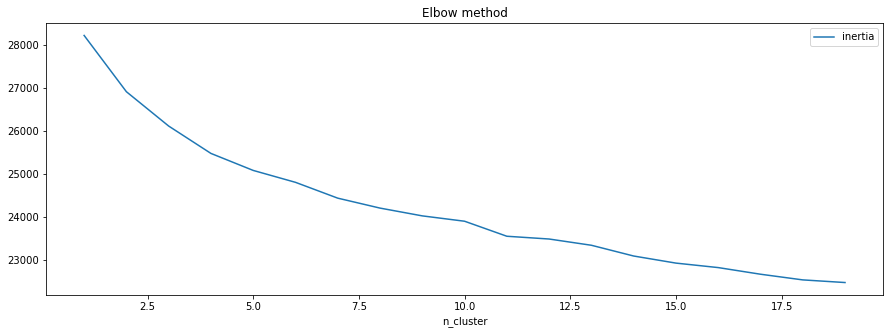

In [48]:
# Elbow Method to identify number of topics

from sklearn.cluster import KMeans

wcss = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=0)
    kmeans.fit(embeddings)
    wcss.append([i, kmeans.inertia_])

title = 'Elbow method'
pd.DataFrame(wcss, columns=['n_cluster', 'inertia']).set_index('n_cluster').plot(figsize=(15,5), title=title);

In [49]:
# Apply KMeans clustering algorithm and assign cluster to each row of dataframe

from sklearn.cluster import KMeans
clustering_model = KMeans(n_clusters=7, random_state=0)
clustering_model.fit(embeddings)
cluster_assignment = clustering_model.labels_
df_env['cluster'] = cluster_assignment
df_env['cluster_'] = df_env.cluster.apply(lambda x: 'cluster_' + str(x))

## Text Lemmatization

In [50]:
import string

df_env['lemmas'] = df_env.clean_text.apply(lambda x: ''.join(e.lower() for e in x if e not in string.punctuation))
df_env['lemmas'] = df_env.lemmas.apply(lambda x: ' '.join(token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and len(token)>1))

## Word Cloud to check main words in each Cluster

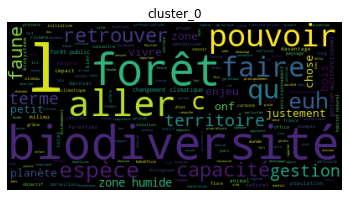

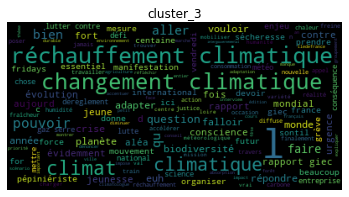

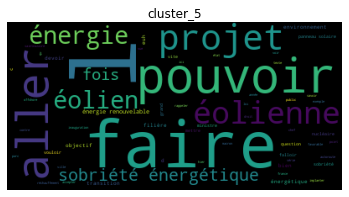

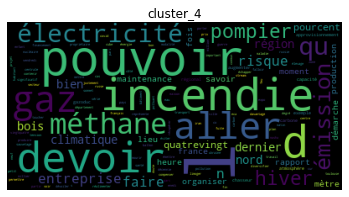

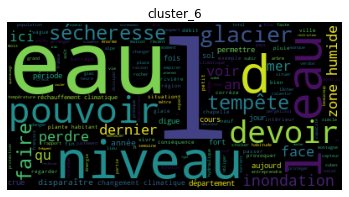

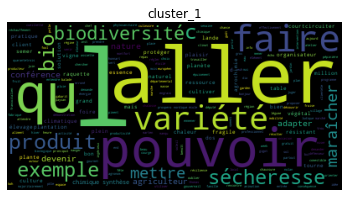

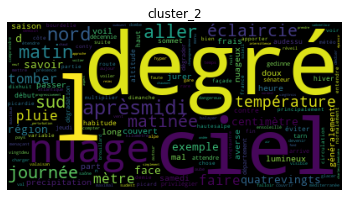

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
STOP_WORDS.union(['euh','l'])

for cluster in df_env.cluster_.unique():
  news = df_env[df_env.cluster_ == cluster]
  doc = ' '.join(e for e in news.lemmas)
  wordcloud = WordCloud(stopwords=STOP_WORDS).generate(doc)

  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title(cluster)
  plt.show()

## Calculate Statistics for Analysis 

In [52]:
stats = df_env.groupby(['CHANNEL','RADIO'], as_index=False).agg({'duration_topic':'sum','START CHUNK':'count','cluster_':'nunique'})
stats.columns = ['channel','media','duration','frequency', 'nb_topics']
stats['media'] = stats.media.map({True:'Radio',False:'TV'})
stats

,channel,media,duration,frequency,nb_topics
0,8-mont-blanc,TV,103.2,7,1
1,arte,TV,26.6,2,2
2,bergerac,Radio,35.6,2,2
3,bfmgrandlittoral-edd,TV,31.0,2,2
4,bfmlyon,TV,63.4,5,3
...,...,...,...,...,...
61,telenantes,TV,201.6,18,5
62,tv-tours,TV,183.0,9,4
63,tv5,TV,16.4,1,1
64,vfm,Radio,74.2,5,3


In [53]:
import plotly.express as px
fig = px.scatter(stats, x="nb_topics", y="frequency",size="duration", color="channel", hover_name="channel", 
                 title='Place du Changement Climatique dans les médias TV et Radio', log_x=True, size_max=60)
fig.show()

In [54]:
fig = px.histogram(stats, x='channel', y='duration', color='media',
                  title="Temps Consacré à l'Environnement").update_xaxes(categoryorder='total descending')
fig.show()

In [55]:
fig = px.histogram(stats, x='channel', y='frequency', color='media',
                  title="Fréquences des Sujets Relatifs à l'Environnement").update_xaxes(categoryorder='total descending')
fig.show()

In [56]:
fig = px.histogram(stats, x='channel', y='nb_topics', color='media',
                  title="Diversité des Thématiques liées à l'Environnement").update_xaxes(categoryorder='total descending')
fig.show()